<a href="https://colab.research.google.com/github/shlok97/Cars-Generator-Self-Attention-DCGAN/blob/master/Car_GAN_TensorflowScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper
%matplotlib inline

In [0]:
tf.reset_default_graph()
def attention(x, ch, scope, reuse=False):
  with tf.variable_scope(scope) as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        f = tf.layers.conv2d(
            x,
            ch // 8,
            1,
            strides=1
        )
        g = tf.layers.conv2d(
            x,
            ch // 8,
            1,
            strides=1
        )
        h = tf.layers.conv2d(
            x,
            ch,
            1,
            strides=1
        )
        # N = h * w
        s = tf.matmul(tf.layers.flatten(g), tf.layers.flatten(f), transpose_b=True) # # [bs, N, N]

        beta = tf.nn.softmax(s)  # attention map

        o = tf.matmul(beta, tf.layers.flatten(h)) # [bs, N, C]
        gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

        o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
        x = gamma * o + x

        return x

In [0]:
def generator(z, batch_size, isTraining = True, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 3 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 64 #Output size of the image
        
        # input size [1, 100]
        
        h0 = tf.reshape(z, [batch_size, 1, 100])
        h0 = tf.nn.relu(h0)
        
        h1 = tf.layers.dense(z, 1024*4*4, activation=tf.nn.relu, reuse=reuse)
#         h1 = tf.keras.layers.Dense(256*4*4, activation=tf.nn.relu)(z)
        h1 = tf.reshape(h1, ([batch_size, 4, 4, 1024]))
        

        h2 = tf.layers.conv2d_transpose(
            h1,
            512,
            3,
            strides=(2, 2),
            padding='same',
        )
        h2 = tf.layers.batch_normalization(h2, training=isTraining)
        
        h2 = tf.nn.leaky_relu(
            h2,
            alpha=0.01,
        )
        
        h2 = attention(h2, 512, scope='g_attn_1', reuse=reuse)
        
        h3 = tf.layers.conv2d_transpose(
            h2,
            256,
            3,
            strides=(2, 2),
            padding='same',
        )
        h3 = tf.layers.batch_normalization(h3, training=isTraining)
        h3 = tf.nn.leaky_relu(
            h3,
            alpha=0.01,
        )
        h3 = attention(h3, 256, scope='g_attn_2', reuse=reuse)

        
        h4 = tf.layers.conv2d_transpose(
            h3,
            128,
            3,
            strides=(2, 2),
            padding='same',
        )
        h4 = tf.layers.batch_normalization(h4, training=isTraining)
        h4 = tf.nn.leaky_relu(
            h4,
            alpha=0.01,
        )
        
        # ATTENTION LAYER
        
        h4 = attention(h4, 128, scope='g_attn_3', reuse=reuse)
        
        h5 = tf.layers.conv2d_transpose(
            h4,
            3,
            3,
            strides=(2, 2),
            padding='same'
        )
        h5 = tf.layers.batch_normalization(h5, training=isTraining)
        h5 = tf.nn.tanh(
            h5
        )
        
        return h5

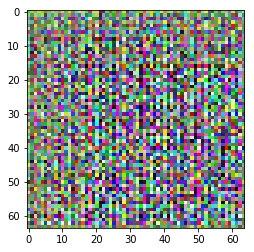

In [0]:
tf.reset_default_graph()
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [1, z_dimensions])
# is_Tr = tf.placeholder(tf.float32, [1, z_dimensions])
sample_image = generator(z_test_placeholder, 1, True, False)
test_z = np.random.uniform(-1, 1, [1,z_dimensions])

sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

my_i = temp.squeeze()
plt.imshow((my_i + 1.)/2.)
plt.show()

In [0]:
def discriminator(x_image, batch_size, reuse=False):
  with tf.variable_scope('discriminator') as scope:
      if (reuse):
          tf.get_variable_scope().reuse_variables()

      img = tf.reshape(x_image, [batch_size, 64, 64, 3])

      conv1 = tf.layers.conv2d(
          img,
          64,
          5,
          strides=(2, 2),
          padding='same',
          reuse=None
      )
      conv1 = tf.nn.leaky_relu(
        conv1,
        alpha=0.05,
      )

      conv1 = tf.layers.dropout(
        conv1,
        rate=0.3,
      )
      
      conv1 = attention(conv1, 64, scope='d_attn_1', reuse=reuse)

      conv2 = tf.layers.conv2d(
          conv1,
          128,
          5,
          strides=(2, 2),
          padding='same',
          reuse=None
      )

      conv2 = tf.nn.leaky_relu(
        conv2,
        alpha=0.05,
      )

      conv2 = tf.layers.dropout(
        conv2,
        rate=0.3,
      )
      
#       ATTENTION LAYER
      conv2 = attention(conv2, 128, scope='d_attn_2', reuse=reuse)

      conv3 = tf.layers.conv2d(
          conv2,
          256,
          5,
          strides=(2, 2),
          padding='same',
          reuse=None
      )

      conv3 = tf.nn.leaky_relu(
        conv3,
        alpha=0.05,
      )

      conv3 = tf.layers.dropout(
        conv3,
        rate=0.3,
      )
      conv3 = attention(conv3, 256, scope='d_attn_3', reuse=reuse)

      flat = tf.layers.flatten(
          conv3,
      )

      logits = tf.layers.dense(
        flat,
        1
      )
      output = tf.sigmoid(logits)
      
      return output, logits
  

In [0]:
new_image = tf.zeros((64, 64, 3))
      

In [0]:
discriminator(new_image, 1)

(<tf.Tensor 'discriminator/Sigmoid:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'discriminator/dense/BiasAdd:0' shape=(1, 1) dtype=float32>)

In [0]:
def loss(input_real, input_z, batch_size):
  label_smoothing = 0.9
  
  
  generated_image = generator(input_z, batch_size)
  
  
  d_output_real, d_logits_real = discriminator(input_real, batch_size)
  d_output_fake, d_logits_fake = discriminator(generated_image, batch_size, reuse=True)
  
  real_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_output_real)*label_smoothing, logits=d_logits_real)
  )
  
  fake_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_output_fake), logits=d_logits_fake)
  )
  
  d_loss =  real_loss + fake_loss
  
  g_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_output_fake)*label_smoothing, logits=d_logits_fake)
  )
  
  return d_loss, g_loss

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [0]:
def show_generator_output(sess, n_images, input_z, out_channel_dim):
  """
  Show example output for the generator
  """
  z_dim = input_z.get_shape().as_list()[-1]
  example_z = np.random.uniform(-1, 1, size=[1, z_dim])
  
  
  samples = sess.run(
      generator(input_z, 1, False, True),
      feed_dict={input_z: example_z})

  plt.imshow((samples[0] + 1.)/2.)
  plt.show()

In [0]:
import os
from PIL import Image
import numpy as np

def get_training_data():
    import matplotlib.image as mpimg

    def load_images(folder):
        training_data = []
        
        for filename in os.listdir(folder):
            img = mpimg.imread(os.path.join(folder, filename))
            if img is not None:
                img = Image.fromarray(img)
                img = img.resize((64,64),Image.ANTIALIAS)
                pixel_array = np.asarray(img)
                if pixel_array.shape == (64, 64, 3):
                    training_data.append(pixel_array)
        return training_data
    
    return load_images("cars_train")

In [0]:
training_data = get_training_data()

In [0]:
def get_batch(batch_size=16):
  batch = []
  
  import random
  
  for i in range(batch_size):
    batch.append(training_data[random.randint(0, len(training_data)-1)])
  return (np.array(batch) / 127.5) - 1.0

W0703 14:45:16.281118 140382739818368 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


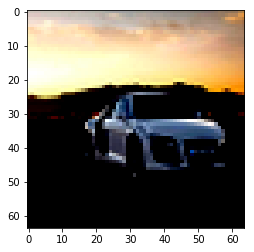

In [0]:
plt.imshow(get_batch()[0])
plt.show()

In [0]:
# (64, 64, 3, 100)

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1):
    """
    Train the GAN
    """
#     input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    input_real, input_z, _ = model_inputs(64, 64, 3, 100)
    
    d_loss, g_loss = loss(input_real, input_z, batch_size)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):

            # values range from -0.5 to 0.5, therefore scale to range -1, 1
            batch_images = get_batch(batch_size)
            steps += 1

            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

            _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

            if steps % 40 == 0:
                # At the end of every 10 epochs, get the losses and print them out
                train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

                _ = show_generator_output(sess, 1, input_z, 3)

Epoch 40/7000... Discriminator Loss: 0.8519... Generator Loss: 1.1474


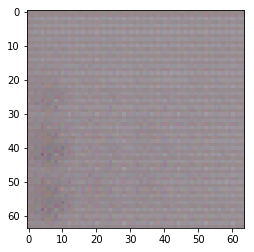

Epoch 80/7000... Discriminator Loss: 1.0675... Generator Loss: 1.0671


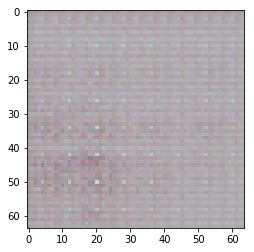

Epoch 120/7000... Discriminator Loss: 1.2107... Generator Loss: 1.0621


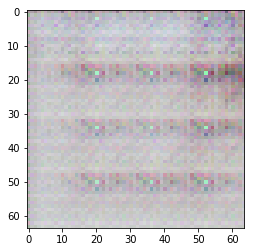

Epoch 160/7000... Discriminator Loss: 1.0906... Generator Loss: 1.0593


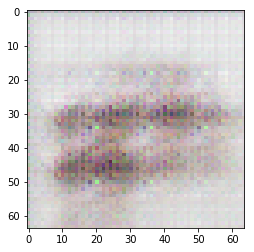

Epoch 200/7000... Discriminator Loss: 1.2978... Generator Loss: 0.7801


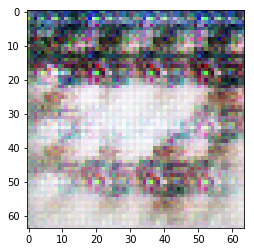

Epoch 240/7000... Discriminator Loss: 1.0735... Generator Loss: 1.2127


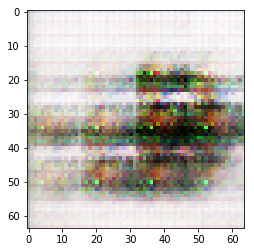

Epoch 280/7000... Discriminator Loss: 1.1701... Generator Loss: 0.9065


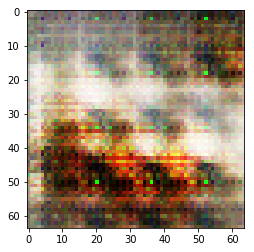

Epoch 320/7000... Discriminator Loss: 1.1127... Generator Loss: 0.7749


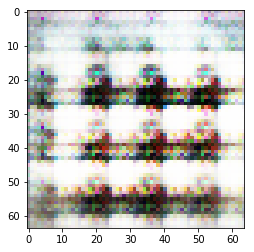

Epoch 360/7000... Discriminator Loss: 1.1577... Generator Loss: 0.8621


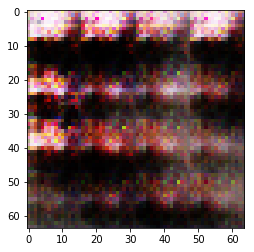

Epoch 400/7000... Discriminator Loss: 1.2964... Generator Loss: 0.8146


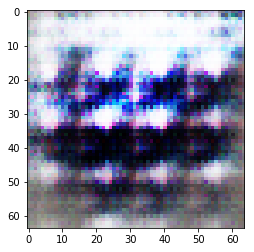

Epoch 440/7000... Discriminator Loss: 1.1076... Generator Loss: 1.2907


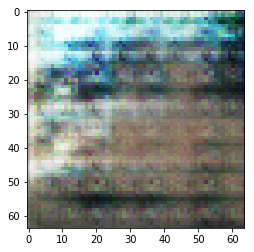

Epoch 480/7000... Discriminator Loss: 1.4739... Generator Loss: 0.7392


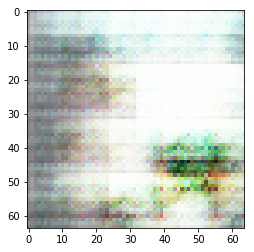

Epoch 520/7000... Discriminator Loss: 1.5057... Generator Loss: 0.6852


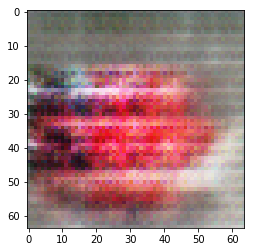

Epoch 560/7000... Discriminator Loss: 1.0232... Generator Loss: 0.8760


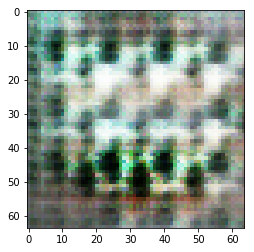

Epoch 600/7000... Discriminator Loss: 1.0097... Generator Loss: 1.0423


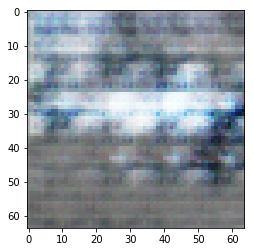

Epoch 640/7000... Discriminator Loss: 1.2614... Generator Loss: 0.8547


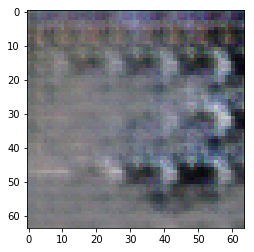

Epoch 680/7000... Discriminator Loss: 1.2887... Generator Loss: 0.8895


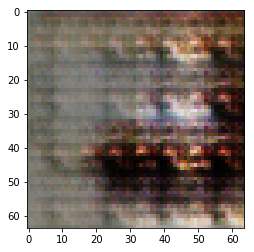

Epoch 720/7000... Discriminator Loss: 0.7215... Generator Loss: 1.4048


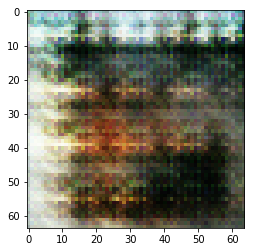

Epoch 760/7000... Discriminator Loss: 0.9293... Generator Loss: 1.5765


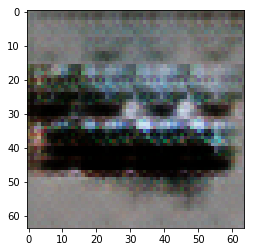

Epoch 800/7000... Discriminator Loss: 0.8933... Generator Loss: 1.5524


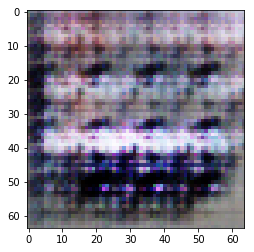

Epoch 840/7000... Discriminator Loss: 0.7715... Generator Loss: 1.1875


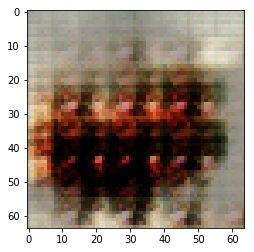

Epoch 880/7000... Discriminator Loss: 0.8909... Generator Loss: 1.1511


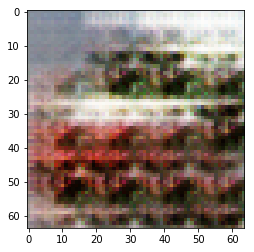

Epoch 920/7000... Discriminator Loss: 0.6470... Generator Loss: 1.4695


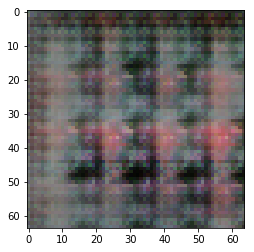

Epoch 960/7000... Discriminator Loss: 0.8860... Generator Loss: 1.1772


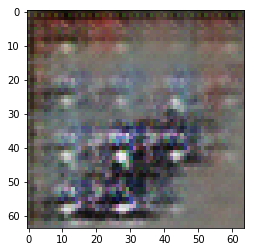

Epoch 1000/7000... Discriminator Loss: 1.4349... Generator Loss: 0.6506


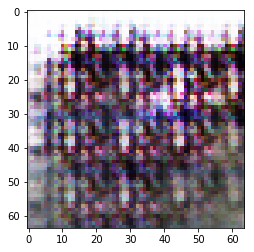

Epoch 1040/7000... Discriminator Loss: 0.8702... Generator Loss: 1.0017


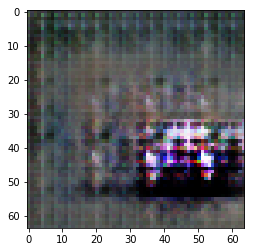

Epoch 1080/7000... Discriminator Loss: 0.7534... Generator Loss: 1.3790


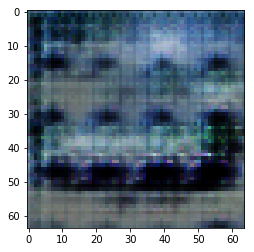

Epoch 1120/7000... Discriminator Loss: 0.9248... Generator Loss: 1.4413


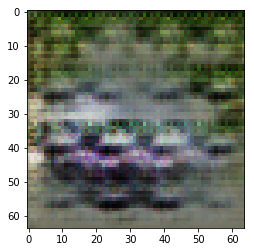

Epoch 1160/7000... Discriminator Loss: 0.8505... Generator Loss: 1.3220


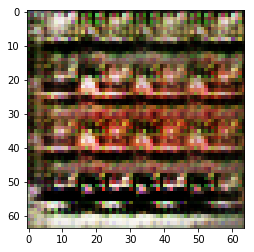

Epoch 1200/7000... Discriminator Loss: 0.6381... Generator Loss: 1.6118


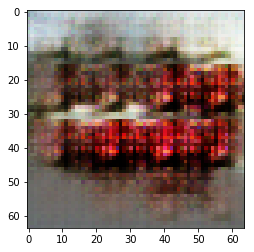

Epoch 1240/7000... Discriminator Loss: 0.6941... Generator Loss: 1.4859


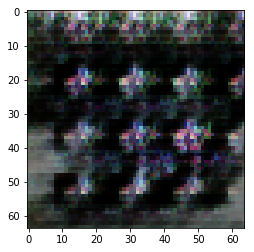

Epoch 1280/7000... Discriminator Loss: 0.6971... Generator Loss: 1.5278


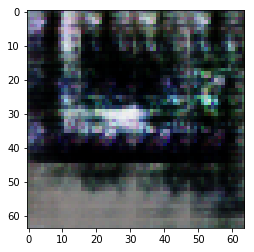

Epoch 1320/7000... Discriminator Loss: 0.8485... Generator Loss: 1.2589


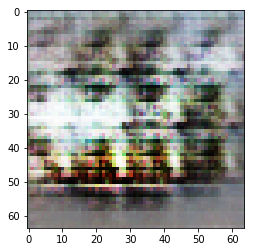

Epoch 1360/7000... Discriminator Loss: 0.6003... Generator Loss: 1.6998


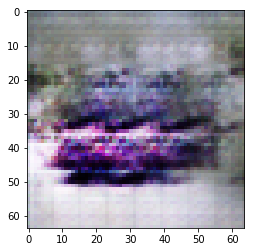

Epoch 1400/7000... Discriminator Loss: 0.6601... Generator Loss: 2.1903


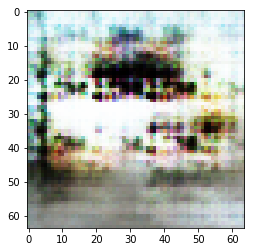

Epoch 1440/7000... Discriminator Loss: 0.7573... Generator Loss: 1.2890


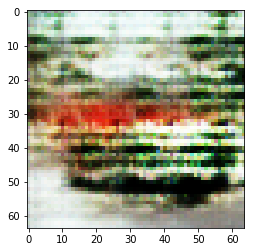

Epoch 1480/7000... Discriminator Loss: 0.5213... Generator Loss: 2.5157


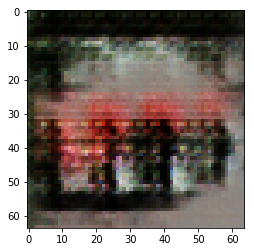

Epoch 1520/7000... Discriminator Loss: 0.6747... Generator Loss: 1.5325


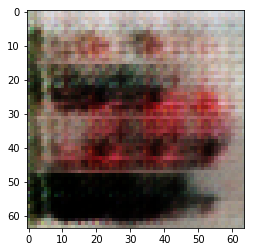

Epoch 1560/7000... Discriminator Loss: 0.7261... Generator Loss: 1.1688


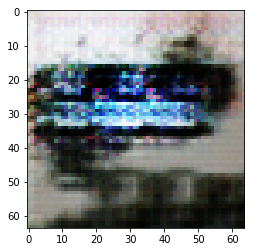

Epoch 1600/7000... Discriminator Loss: 0.4527... Generator Loss: 2.9697


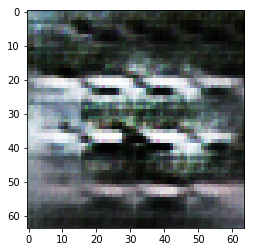

Epoch 1640/7000... Discriminator Loss: 0.7306... Generator Loss: 1.3403


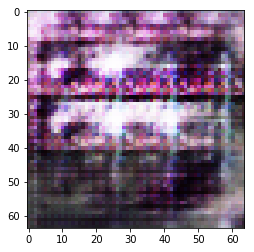

Epoch 1680/7000... Discriminator Loss: 0.4472... Generator Loss: 2.4305


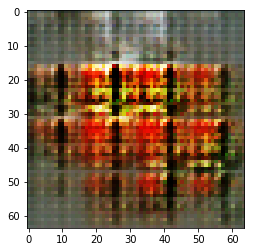

Epoch 1720/7000... Discriminator Loss: 0.8738... Generator Loss: 1.1965


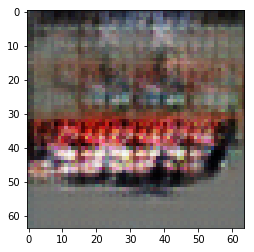

Epoch 1760/7000... Discriminator Loss: 0.4299... Generator Loss: 3.1856


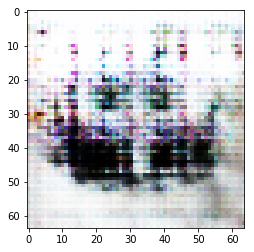

Epoch 1800/7000... Discriminator Loss: 0.4634... Generator Loss: 2.6312


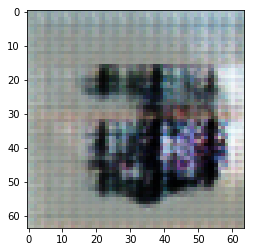

Epoch 1840/7000... Discriminator Loss: 0.6380... Generator Loss: 1.4466


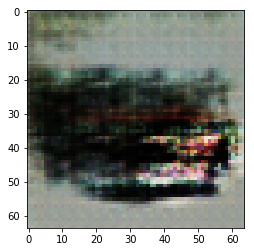

Epoch 1880/7000... Discriminator Loss: 0.5030... Generator Loss: 2.0741


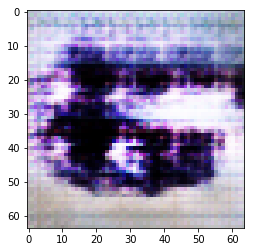

Epoch 1920/7000... Discriminator Loss: 0.5340... Generator Loss: 1.7537


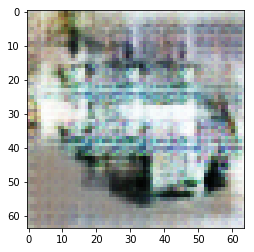

Epoch 1960/7000... Discriminator Loss: 0.4957... Generator Loss: 2.1846


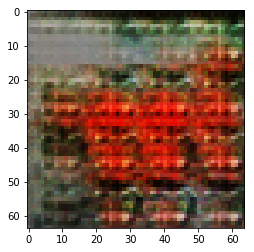

Epoch 2000/7000... Discriminator Loss: 0.4868... Generator Loss: 2.1611


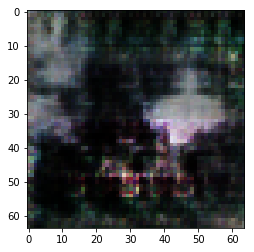

Epoch 2040/7000... Discriminator Loss: 0.4336... Generator Loss: 3.2328


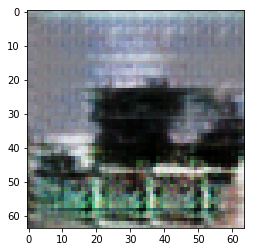

Epoch 2080/7000... Discriminator Loss: 0.5682... Generator Loss: 2.0029


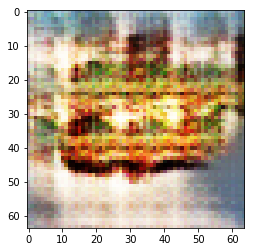

Epoch 2120/7000... Discriminator Loss: 0.4688... Generator Loss: 2.1233


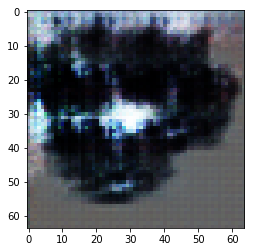

Epoch 2160/7000... Discriminator Loss: 0.7666... Generator Loss: 1.0934


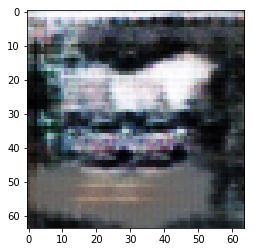

Epoch 2200/7000... Discriminator Loss: 0.8135... Generator Loss: 1.1582


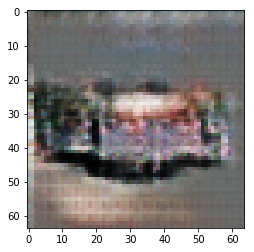

Epoch 2240/7000... Discriminator Loss: 0.4217... Generator Loss: 2.8219


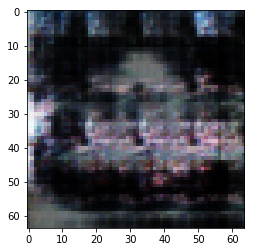

Epoch 2280/7000... Discriminator Loss: 0.8759... Generator Loss: 1.0296


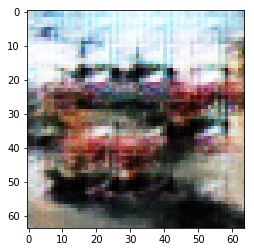

Epoch 2320/7000... Discriminator Loss: 0.4884... Generator Loss: 2.3565


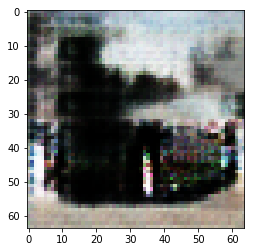

Epoch 2360/7000... Discriminator Loss: 1.0971... Generator Loss: 0.7721


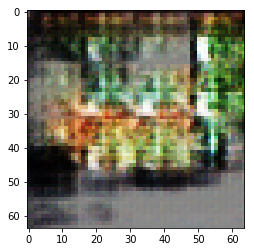

Epoch 2400/7000... Discriminator Loss: 0.9702... Generator Loss: 0.9178


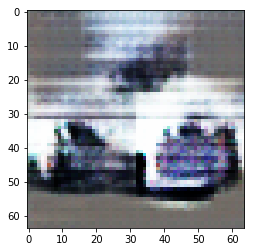

Epoch 2440/7000... Discriminator Loss: 0.5936... Generator Loss: 1.7441


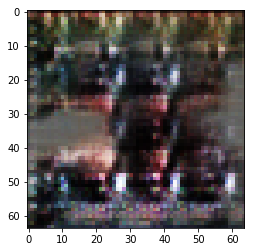

Epoch 2480/7000... Discriminator Loss: 0.5142... Generator Loss: 1.8640


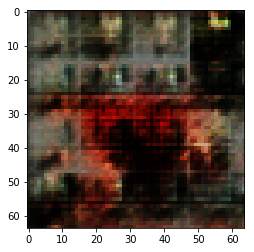

Epoch 2520/7000... Discriminator Loss: 0.9173... Generator Loss: 1.0583


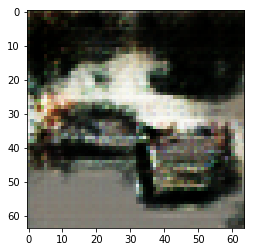

Epoch 2560/7000... Discriminator Loss: 0.7078... Generator Loss: 1.5082


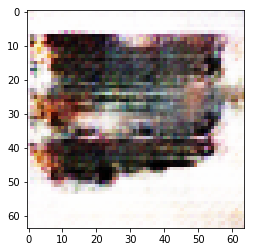

Epoch 2600/7000... Discriminator Loss: 0.5192... Generator Loss: 2.1797


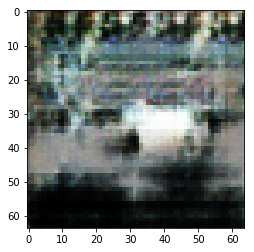

Epoch 2640/7000... Discriminator Loss: 0.5995... Generator Loss: 1.5783


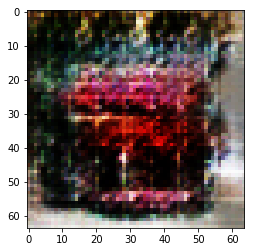

Epoch 2680/7000... Discriminator Loss: 0.6537... Generator Loss: 1.5167


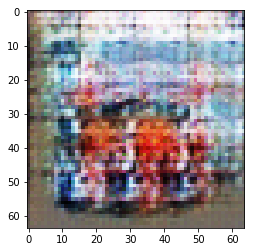

Epoch 2720/7000... Discriminator Loss: 0.5910... Generator Loss: 1.9642


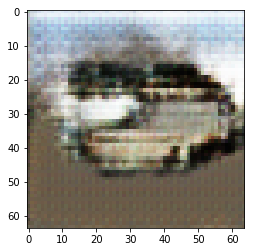

Epoch 2760/7000... Discriminator Loss: 0.5697... Generator Loss: 1.8423


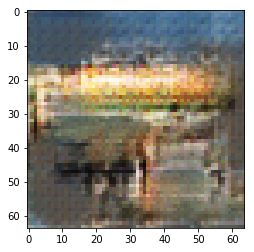

Epoch 2800/7000... Discriminator Loss: 1.0008... Generator Loss: 0.8697


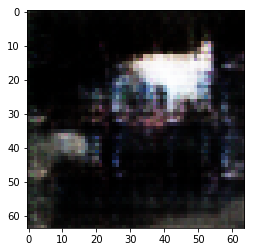

Epoch 2840/7000... Discriminator Loss: 1.0494... Generator Loss: 1.0336


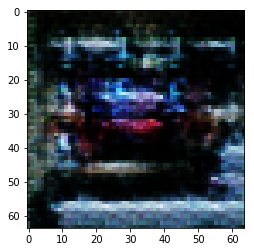

Epoch 2880/7000... Discriminator Loss: 0.5155... Generator Loss: 1.8785


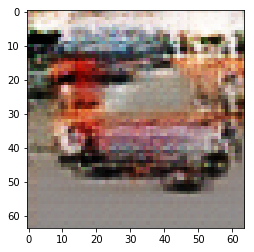

Epoch 2920/7000... Discriminator Loss: 0.4911... Generator Loss: 2.1471


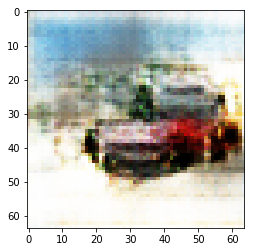

Epoch 2960/7000... Discriminator Loss: 0.6808... Generator Loss: 1.5174


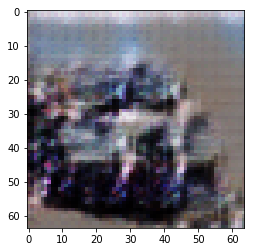

Epoch 3000/7000... Discriminator Loss: 0.4498... Generator Loss: 2.8746


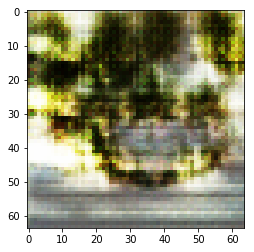

Epoch 3040/7000... Discriminator Loss: 0.5260... Generator Loss: 1.9610


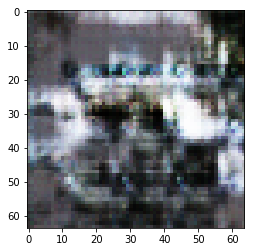

Epoch 3080/7000... Discriminator Loss: 0.7973... Generator Loss: 1.2049


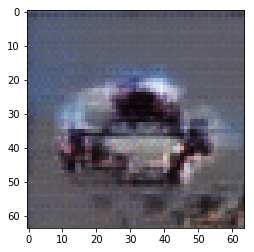

Epoch 3120/7000... Discriminator Loss: 0.7485... Generator Loss: 1.3232


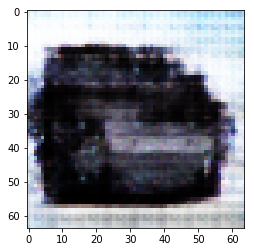

Epoch 3160/7000... Discriminator Loss: 1.1480... Generator Loss: 0.7941


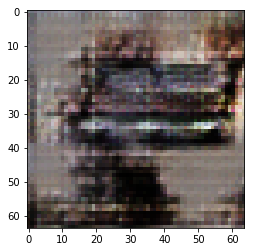

Epoch 3200/7000... Discriminator Loss: 0.5699... Generator Loss: 1.7686


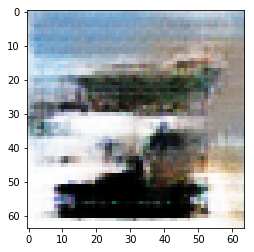

Epoch 3240/7000... Discriminator Loss: 0.7576... Generator Loss: 1.2508


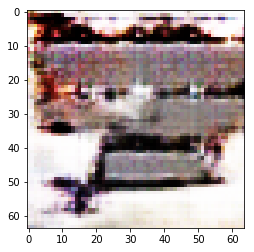

Epoch 3280/7000... Discriminator Loss: 0.5887... Generator Loss: 1.6715


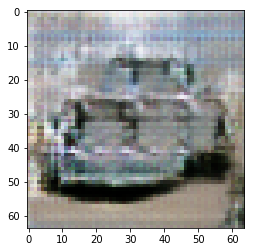

Epoch 3320/7000... Discriminator Loss: 1.5879... Generator Loss: 0.5296


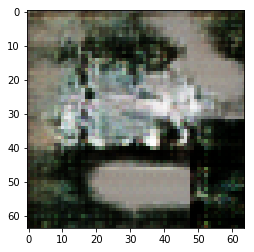

Epoch 3360/7000... Discriminator Loss: 0.4812... Generator Loss: 2.0827


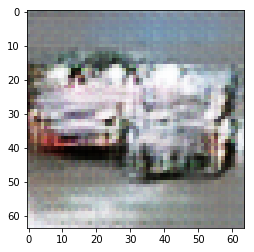

Epoch 3400/7000... Discriminator Loss: 0.8123... Generator Loss: 1.1300


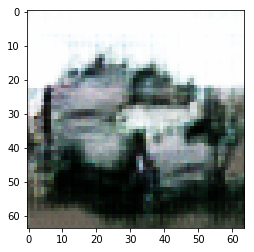

Epoch 3440/7000... Discriminator Loss: 0.4231... Generator Loss: 3.2967


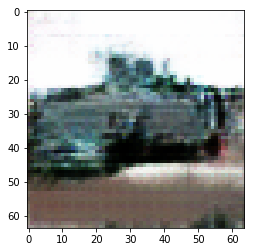

Epoch 3480/7000... Discriminator Loss: 0.8895... Generator Loss: 0.9892


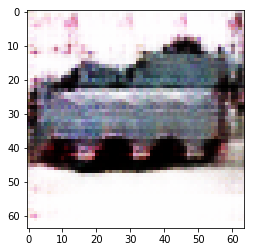

Epoch 3520/7000... Discriminator Loss: 0.6684... Generator Loss: 1.4304


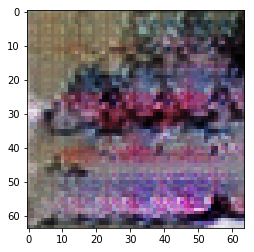

Epoch 3560/7000... Discriminator Loss: 0.9331... Generator Loss: 0.9504


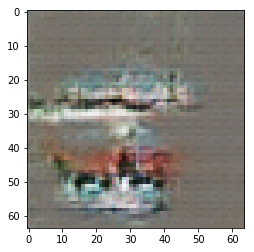

Epoch 3600/7000... Discriminator Loss: 0.5114... Generator Loss: 2.2423


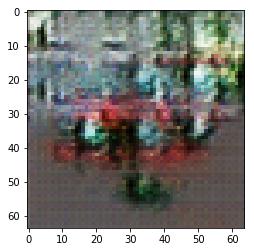

Epoch 3640/7000... Discriminator Loss: 0.4653... Generator Loss: 2.4457


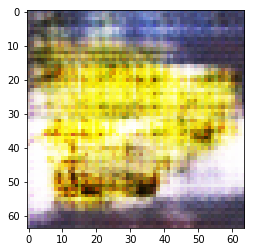

Epoch 3680/7000... Discriminator Loss: 0.6316... Generator Loss: 1.4584


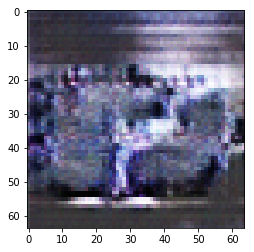

Epoch 3720/7000... Discriminator Loss: 0.5203... Generator Loss: 1.8718


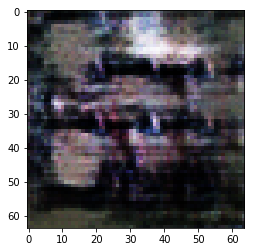

Epoch 3760/7000... Discriminator Loss: 0.5180... Generator Loss: 2.6233


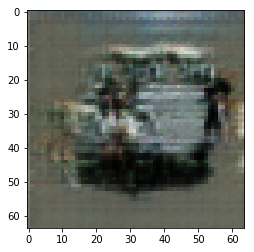

Epoch 3800/7000... Discriminator Loss: 0.7018... Generator Loss: 1.2637


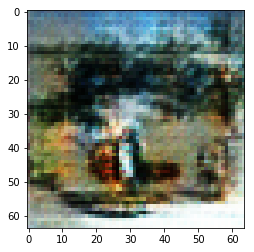

Epoch 3840/7000... Discriminator Loss: 0.4692... Generator Loss: 3.0863


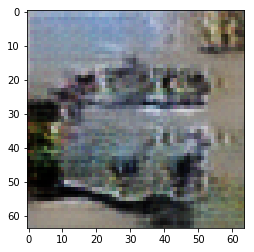

Epoch 3880/7000... Discriminator Loss: 0.5325... Generator Loss: 1.8545


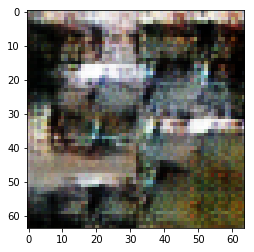

Epoch 3920/7000... Discriminator Loss: 0.5495... Generator Loss: 2.0386


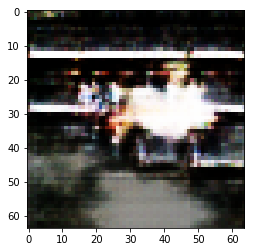

Epoch 3960/7000... Discriminator Loss: 0.5995... Generator Loss: 1.7879


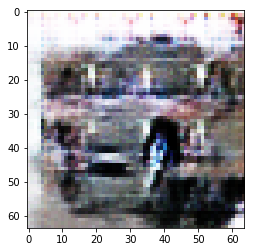

Epoch 4000/7000... Discriminator Loss: 0.4424... Generator Loss: 2.5618


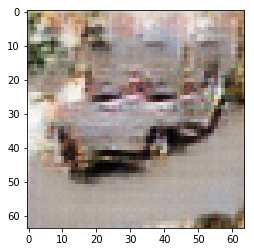

Epoch 4040/7000... Discriminator Loss: 0.5427... Generator Loss: 1.8507


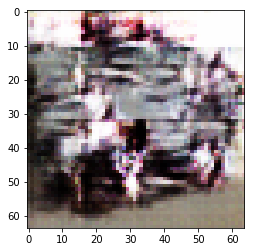

Epoch 4080/7000... Discriminator Loss: 0.9274... Generator Loss: 0.9249


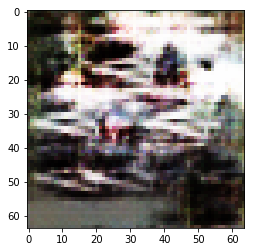

Epoch 4120/7000... Discriminator Loss: 0.7686... Generator Loss: 1.3389


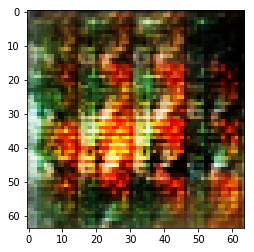

Epoch 4160/7000... Discriminator Loss: 0.5790... Generator Loss: 1.9067


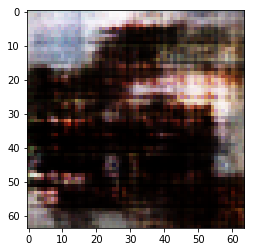

Epoch 4200/7000... Discriminator Loss: 0.5194... Generator Loss: 2.0482


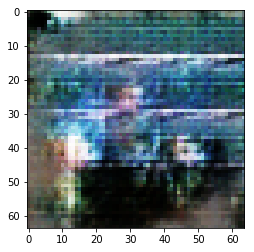

Epoch 4240/7000... Discriminator Loss: 0.7216... Generator Loss: 1.3446


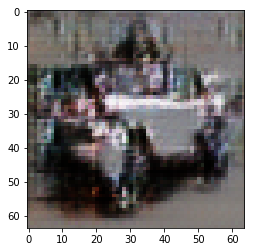

Epoch 4280/7000... Discriminator Loss: 0.6818... Generator Loss: 1.5671


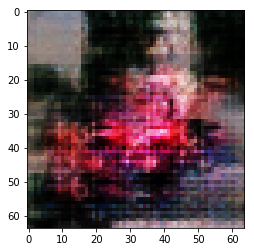

Epoch 4320/7000... Discriminator Loss: 0.6509... Generator Loss: 1.6809


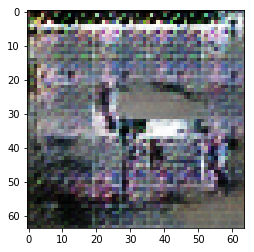

Epoch 4360/7000... Discriminator Loss: 0.6565... Generator Loss: 1.5137


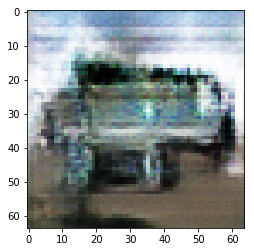

Epoch 4400/7000... Discriminator Loss: 0.7163... Generator Loss: 1.3163


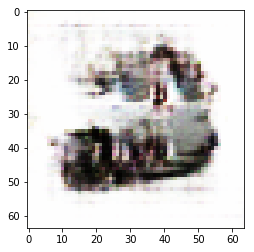

Epoch 4440/7000... Discriminator Loss: 1.3213... Generator Loss: 1.9819


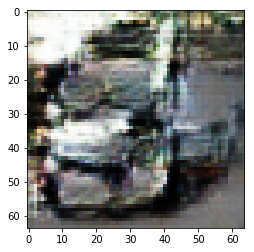

Epoch 4480/7000... Discriminator Loss: 1.5313... Generator Loss: 0.5306


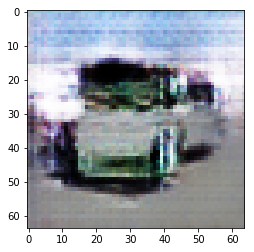

Epoch 4520/7000... Discriminator Loss: 0.5187... Generator Loss: 1.9296


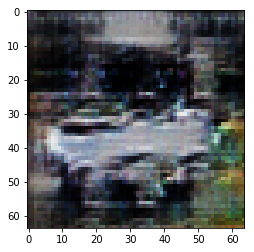

Epoch 4560/7000... Discriminator Loss: 1.0713... Generator Loss: 0.8331


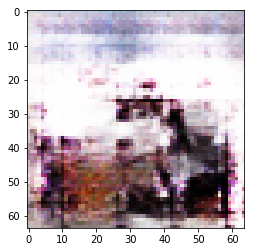

Epoch 4600/7000... Discriminator Loss: 0.8010... Generator Loss: 1.1474


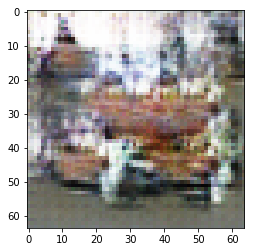

Epoch 4640/7000... Discriminator Loss: 0.7171... Generator Loss: 1.8104


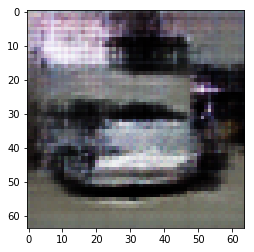

Epoch 4680/7000... Discriminator Loss: 0.5588... Generator Loss: 1.9019


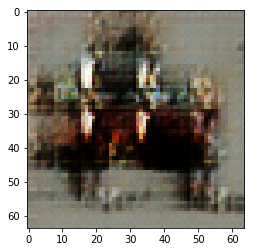

Epoch 4720/7000... Discriminator Loss: 0.5266... Generator Loss: 2.2583


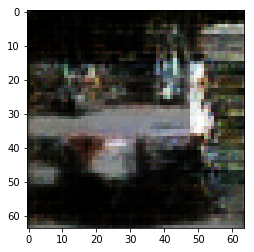

Epoch 4760/7000... Discriminator Loss: 0.7839... Generator Loss: 1.0995


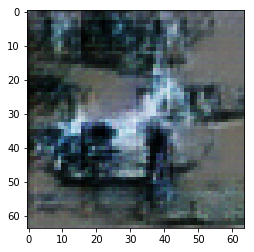

Epoch 4800/7000... Discriminator Loss: 0.7296... Generator Loss: 1.2373


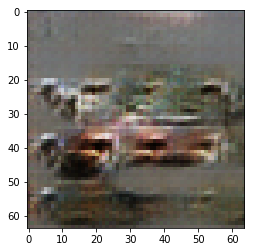

Epoch 4840/7000... Discriminator Loss: 0.9017... Generator Loss: 1.1327


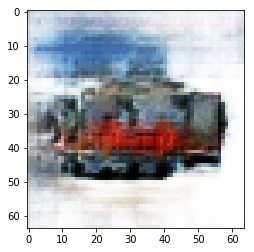

Epoch 4880/7000... Discriminator Loss: 0.4803... Generator Loss: 2.2264


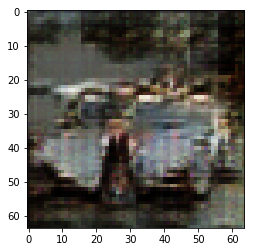

Epoch 4920/7000... Discriminator Loss: 0.5593... Generator Loss: 1.7834


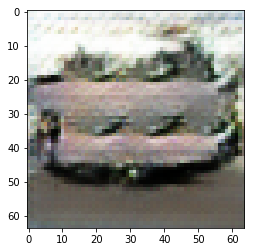

Epoch 4960/7000... Discriminator Loss: 0.6842... Generator Loss: 1.4448


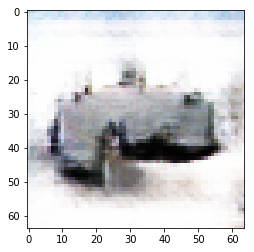

Epoch 5000/7000... Discriminator Loss: 0.5122... Generator Loss: 1.8920


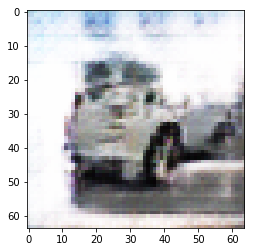

Epoch 5040/7000... Discriminator Loss: 0.5097... Generator Loss: 1.9861


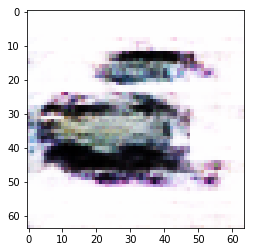

Epoch 5080/7000... Discriminator Loss: 0.4468... Generator Loss: 2.4847


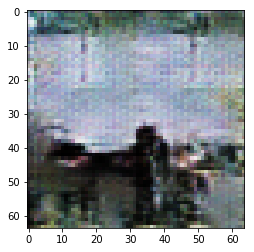

Epoch 5120/7000... Discriminator Loss: 0.6143... Generator Loss: 1.7192


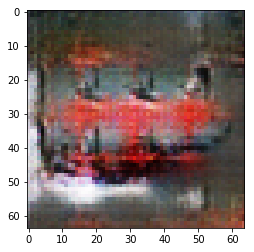

Epoch 5160/7000... Discriminator Loss: 0.5229... Generator Loss: 2.6668


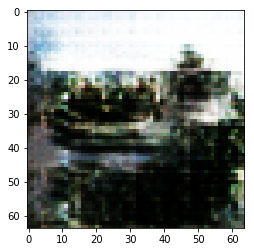

Epoch 5200/7000... Discriminator Loss: 0.4544... Generator Loss: 2.9283


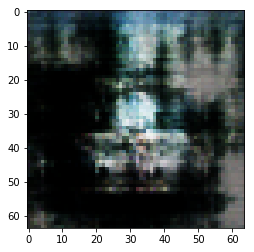

Epoch 5240/7000... Discriminator Loss: 0.5805... Generator Loss: 1.8799


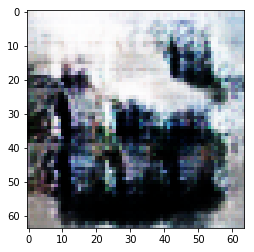

Epoch 5280/7000... Discriminator Loss: 0.8333... Generator Loss: 1.3074


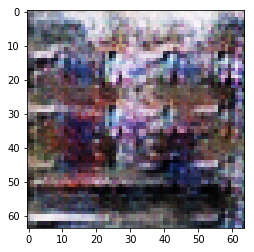

Epoch 5320/7000... Discriminator Loss: 0.4408... Generator Loss: 2.8026


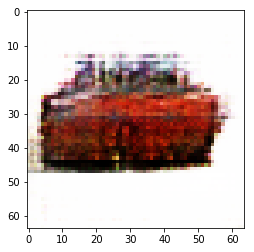

Epoch 5360/7000... Discriminator Loss: 0.6416... Generator Loss: 1.4921


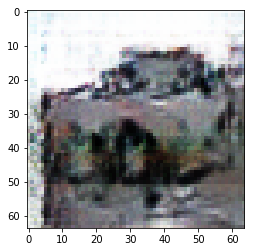

Epoch 5400/7000... Discriminator Loss: 0.6310... Generator Loss: 1.4262


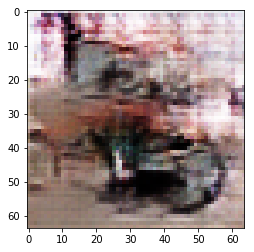

Epoch 5440/7000... Discriminator Loss: 0.5589... Generator Loss: 1.6740


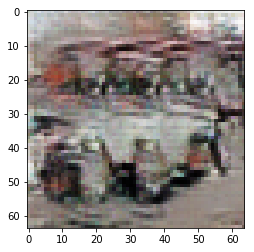

Epoch 5480/7000... Discriminator Loss: 0.5459... Generator Loss: 1.7530


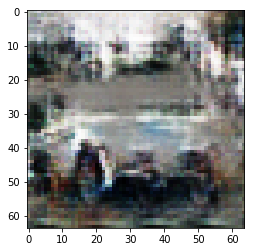

Epoch 5520/7000... Discriminator Loss: 0.7070... Generator Loss: 1.5477


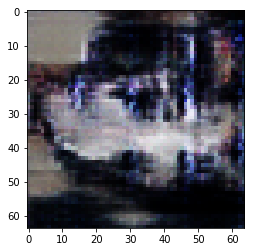

Epoch 5560/7000... Discriminator Loss: 0.4297... Generator Loss: 2.6326


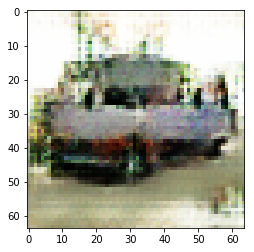

Epoch 5600/7000... Discriminator Loss: 0.7786... Generator Loss: 1.1830


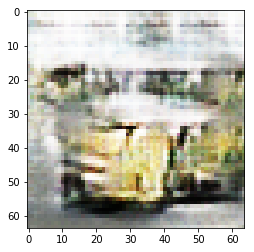

Epoch 5640/7000... Discriminator Loss: 0.5449... Generator Loss: 2.0413


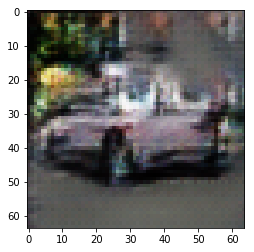

Epoch 5680/7000... Discriminator Loss: 0.5874... Generator Loss: 1.7802


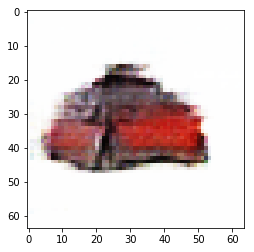

Epoch 5720/7000... Discriminator Loss: 0.4141... Generator Loss: 2.8411


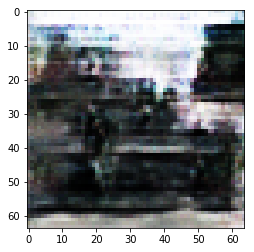

Epoch 5760/7000... Discriminator Loss: 0.6497... Generator Loss: 1.6273


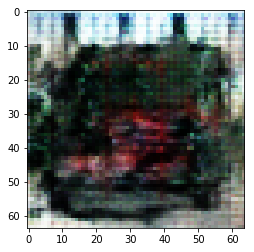

Epoch 5800/7000... Discriminator Loss: 0.4674... Generator Loss: 2.3058


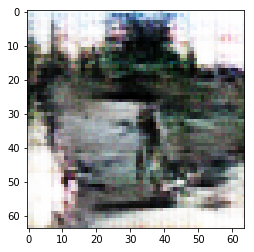

Epoch 5840/7000... Discriminator Loss: 0.6703... Generator Loss: 1.2848


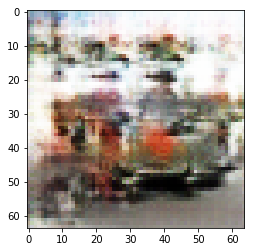

Epoch 5880/7000... Discriminator Loss: 0.5632... Generator Loss: 1.8415


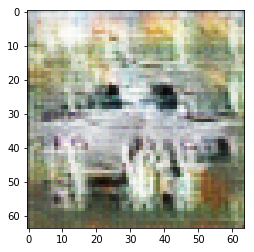

Epoch 5920/7000... Discriminator Loss: 0.4317... Generator Loss: 2.6220


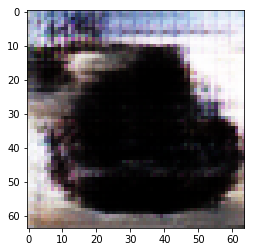

Epoch 5960/7000... Discriminator Loss: 1.8198... Generator Loss: 0.4466


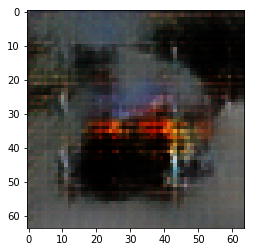

Epoch 6000/7000... Discriminator Loss: 0.6824... Generator Loss: 1.3345


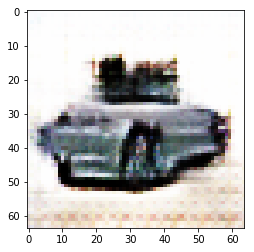

Epoch 6040/7000... Discriminator Loss: 0.6217... Generator Loss: 1.7029


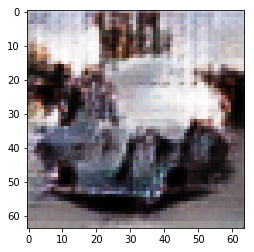

Epoch 6080/7000... Discriminator Loss: 0.4064... Generator Loss: 3.2793


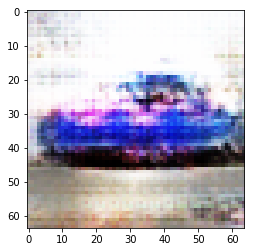

Epoch 6120/7000... Discriminator Loss: 0.5788... Generator Loss: 1.9228


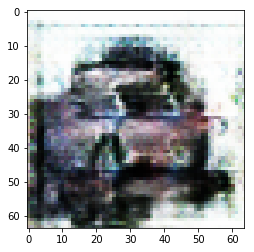

Epoch 6160/7000... Discriminator Loss: 0.4646... Generator Loss: 2.6425


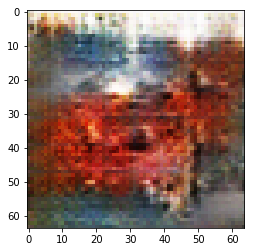

Epoch 6200/7000... Discriminator Loss: 0.4441... Generator Loss: 2.8327


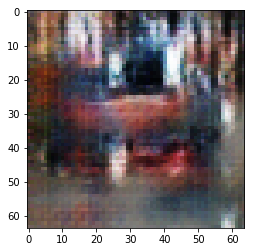

Epoch 6240/7000... Discriminator Loss: 0.8003... Generator Loss: 1.1853


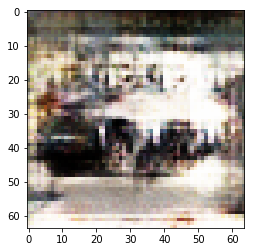

Epoch 6280/7000... Discriminator Loss: 0.6234... Generator Loss: 1.7785


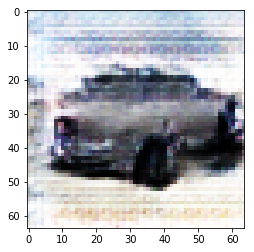

Epoch 6320/7000... Discriminator Loss: 0.9179... Generator Loss: 1.0977


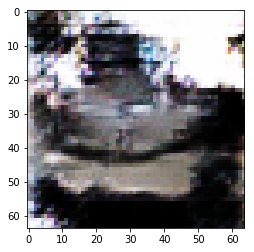

Epoch 6360/7000... Discriminator Loss: 0.5106... Generator Loss: 2.1003


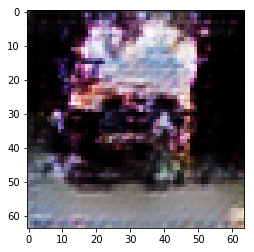

Epoch 6400/7000... Discriminator Loss: 0.9579... Generator Loss: 1.0459


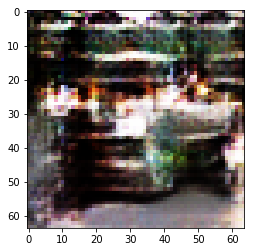

Epoch 6440/7000... Discriminator Loss: 0.5304... Generator Loss: 1.8222


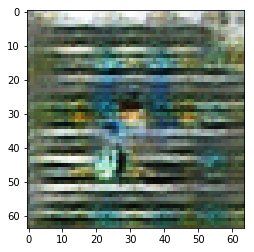

Epoch 6480/7000... Discriminator Loss: 0.4490... Generator Loss: 2.2902


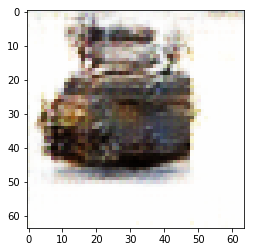

Epoch 6520/7000... Discriminator Loss: 0.4368... Generator Loss: 2.6573


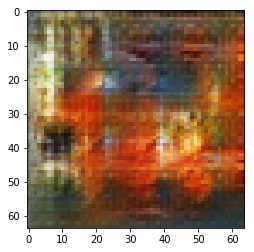

Epoch 6560/7000... Discriminator Loss: 0.4228... Generator Loss: 2.6282


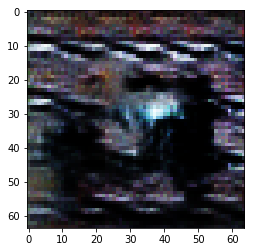

Epoch 6600/7000... Discriminator Loss: 0.7043... Generator Loss: 1.2775


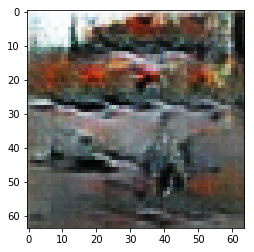

Epoch 6640/7000... Discriminator Loss: 0.4645... Generator Loss: 2.2195


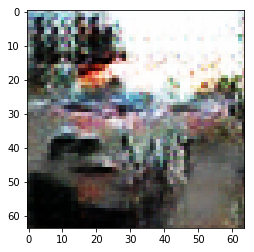

Epoch 6680/7000... Discriminator Loss: 0.5432... Generator Loss: 1.8443


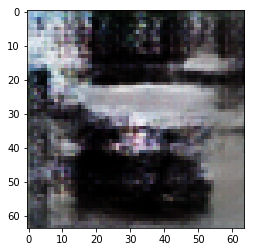

Epoch 6720/7000... Discriminator Loss: 0.5136... Generator Loss: 1.8973


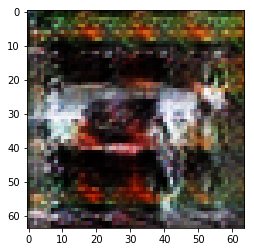

Epoch 6760/7000... Discriminator Loss: 0.6251... Generator Loss: 1.4743


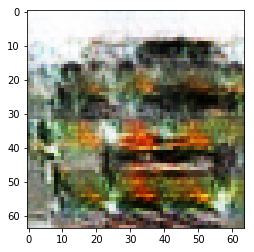

Epoch 6800/7000... Discriminator Loss: 0.4384... Generator Loss: 2.7486


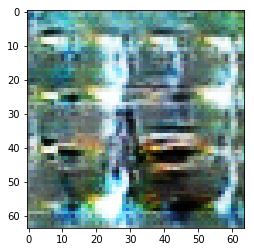

Epoch 6840/7000... Discriminator Loss: 0.4915... Generator Loss: 2.4536


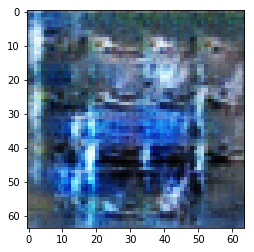

Epoch 6880/7000... Discriminator Loss: 0.3937... Generator Loss: 3.5780


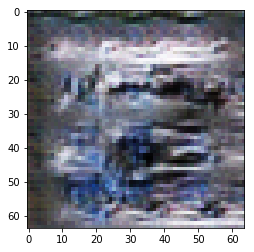

Epoch 6920/7000... Discriminator Loss: 0.5263... Generator Loss: 1.9264


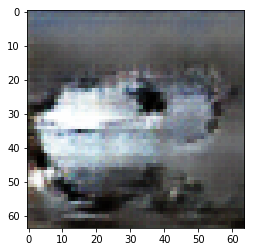

Epoch 6960/7000... Discriminator Loss: 0.7589... Generator Loss: 1.2406


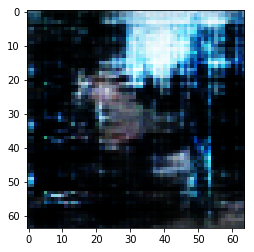

Epoch 7000/7000... Discriminator Loss: 0.4161... Generator Loss: 2.5923


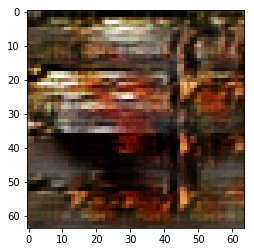

In [0]:
batch_size = 24
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 7000

tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1)